[[Python] Keras-RLで簡単に強化学習(DQN)を試す](http://qiita.com/inoory/items/e63ade6f21766c7c2393)を参考に、エージェントを作成する。FXの自動取引を行い、利益を出すのが目標。

In [ ]:
import gym
import gym.spaces
import numpy as np
import pandas as pd
import datetime as dt
import enum
from logging import getLogger, StreamHandler, DEBUG, INFO
import time
import keras
import os
import warnings
import itertools

Using TensorFlow backend.


In [ ]:
logger = getLogger(__name__)
handler = StreamHandler()
handler.setLevel(INFO)
logger.setLevel(INFO)
logger.addHandler(handler)

class DebugTools:
    def now():
        return dt.datetime.now() + dt.timedelta(hours=9)
    def now_str():    
        return DebugTools.now().strftime('%y/%m/%d %H:%M:%S')

class Action(enum.Enum):
    SELL = -1; STAY = 0; BUY = +1

In [ ]:
class HistData:
    def __init__(self, date_range=None):
        self.csv_path = 'USDJPY.hst_.csv'
        self.csv_data = pd.read_csv(self.csv_path, index_col=0, parse_dates=True, header=0)
        self.date_range = date_range
        #self._current_index = 0

    def set_date_range(self, date_range):
        self.date_range = date_range

    def data(self):
        if self.date_range is None:
            return self.csv_data
        else:
            return self.csv_data[self.date_range]

    def first(self):
        return self.data().ix[0]

    def last(self):
        return self.data().ix[-1]

    def at(self, at):
        return self.data().ix[at]

    def value_at(self, at):
        price = self.data().ix[at]
        if price is None:
            return None
        else:
            return price['Close']
'''
    def current(self):
        return self.data().ix[self._current_index]

    def current_value(self):
        return self.current()['Close']
    
    def next(self):
        if len(self.data()) - 1 > self._current_index:
            self._current_index += 1
            return self.current()
        else:
            return None

    def next_price(self):
        next_val = self.next()
        if next_val is None:
            return None
        else:
            return next_val['Close']
        
    def current_index(self):
        return self._current_index
'''
    def max_value(self):
        return self.data()[['High']].max()['High']

    def min_value(self):
        return self.data()[['Low']].min()['Low']

    def dates(self):
        return self.data().index.values

    ''' 引数の日時がデータフレームに含まれるか '''
    def has_datetime(self, datetime64_value):
        try:
            h.data().loc[datetime64_value]
            return True
        except KeyError:
            return False

    def _get_nearist_index(self, before_or_after, datetime):
        if before_or_after == 'before':
            offset = -1
        else:
            offset = 0
        index = max(h.data().index.searchsorted(datetime) + offset, 0)
        return self.data().ix[self.data().index[index]]

    ''' 引数の日時を含まない直前に存在する値を取得する '''        
    def get_last_exist_datetime(self, datetime64_value):
        return self._get_nearist_index('before', datetime64_value)
        
    ''' 引数の日時を含む直後に存在する値を取得する '''
    def get_next_exist_datetime(self, datetime64_value):
        return self._get_nearist_index('after', datetime64_value)
    
    ''' fromとtoの日時の差が閾値内にあるか否か '''
    def is_datetime_diff_in_threshould(self, from_datetime, to_datetime, threshold_timedelta):
        last_datetime = h.get_last_exist_datetime(from_datetime)
        next_exist_datetime = h.get_next_exist_datetime(to_datetime)
        delta = next_exist_datetime.name - last_datetime.name
        return delta <= threshold_timedelta

In [ ]:
''' ポジション '''
class Position:
    def __init__(self, buy_or_sell, price, amount):
        self.price = price
        self.amount = amount
        self.buy_or_sell = buy_or_sell
    
    ''' 総利益を計算する '''
    def calc_profit_by(self, now_price):
        return self._calc_unit_profit_by(now_price) * self.amount

    ''' 単位あたりの利益を計算する '''
    def _calc_unit_profit_by(self, now_price):
        if self.buy_or_sell == 'buy' or self.buy_or_sell == Action.BUY.value:
            return now_price - self.price
        else:
            return self.price - now_price

In [ ]:
class FXTrade(gym.core.Env):
    AMOUNT_UNIT = 50000
    THRESHOULD_TIME_DELTA = dt.timedelta(days=1)
    
    def __init__(self, initial_cash, spread, hist_data, seed_value=100000, logger=None):
        self.hist_data = hist_data
        self.initial_cash = initial_cash
        self.cash = initial_cash
        self.spread = spread
        self._positions = []
        self._max_date = self._datetime2float(hist_data.dates().max())
        self._min_date = self._datetime2float(hist_data.dates().min())
        self._seed = seed_value
        np.random.seed(seed_value)

        high = np.array([self._max_date, hist_data.max_value()])
        low = np.array([self._min_date, hist_data.min_value()])
        self.action_space = gym.spaces.Discrete(3)
        self.observation_space = gym.spaces.Box(low = low, high = high) # DateFrame, Close prise
        
    def get_now_datetime_as(self, datetime_or_float):
        if datetime_or_float == 'float':
            return self._now_datetime
        else:
            dt = self._float2datetime(self._now_datetime)
            return dt
    
    def _set_now_datetime(self, value):
        if isinstance(value, float):
            assert self._min_date <= value, value
            assert value <= self._max_date, value
            self._now_datetime = value
            return value
        else:
            assert self._min_date <= self._datetime2float(value), '%f <= %f, %s' % (self._min_date, self._datetime2float(value), value)
            assert self._datetime2float(value) <= self._max_date, '%f <= %f, %s' % (self._datetime2float(value), self._max_date, value)
            float_val = self._datetime2float(value)
            self._now_datetime = float_val
            return float_val
            
    def setseed(self, seed_value):
        self._seed = seed_value
        print('Set seed value: %d' % self._seed)
        return seed_value
        
    def _seed(self):
        return self._seed
    
    def _datetime2float(self, datetime64_value):
        try:
            float_val = float(str(datetime64_value.astype('uint64'))[:10])
            return float_val
        except:
            logger.error('_datetime2float except')
            import pdb; pdb.set_trace()
    
    def _float2datetime(self, float_timestamp):
        try:
            datetime_val = np.datetime64(dt.datetime.utcfromtimestamp(float_timestamp))
            return datetime_val
        except:
            logger.error('_float2datetime except')
            import pdb; pdb.set_trace()
    
    ''' 総含み益を計算する '''
    def _calc_total_unrealized_gain_by(self, now_close_value):
        if not self._positions: # positions is empty
            return 0
        total_profit = 0
        for position in self._positions:
            total_profit += position.calc_profit_by(now_close_value)
        return total_profit
    
    ''' 全ポジションを決済する '''
    def _liquidate_all_positions_by(self, now_price):
        total_profit = 0
        buy_or_sell = self._positions[0].buy_or_sell
        
        for position in self._positions:
            total_profit += position.calc_profit_by(now_price)
        self._positions = []
        self.cash += total_profit
        return total_profit
        
    ''' 注文を出す '''
    def _order(self, buy_or_sell, now_price, amount):
        position = Position(buy_or_sell=buy_or_sell, price=now_price, amount=amount)
        self._positions.append(position)
        return position
    
    def _get_price_of(self, buy_or_sell, now_buy_price, now_sell_price):
        if buy_or_sell == Action.BUY.value or buy_or_sell == Action.STAY.value:
            return now_buy_price
        elif buy_or_sell == Action.SELL.value:
            return now_sell_price
        else:
            return None

    ''' 各stepごとに呼ばれる
        actionを受け取り、次のstateとreward、episodeが終了したかどうかを返すように実装 '''
    def _step(self, action):
        logger.debug('_step STARTED')
        
        # actionを受け取り、次のstateを決定
        buy_or_sell_or_stay = action - 1
        assert buy_or_sell_or_stay == -1 or \
            buy_or_sell_or_stay == 0 or \
            buy_or_sell_or_stay == 1, 'buy_or_sell_or_stay: %d' % buy_or_sell_or_stay
        
        dminute = 1 # minuteの増加量
        # 今注目している日時を更新
        logger.debug('今注目している日時を更新')
        #import pdb; pdb.set_trace()
        previous_datetime = self.get_now_datetime_as('datetime')
        now_datetime = previous_datetime + np.timedelta64(dminute, 'm')
                
        logger.debug('before')
        logger.debug(now_datetime)
        logger.debug(self._now_datetime)
        #import pdb; pdb.set_trace()
        self._set_now_datetime(now_datetime)
        logger.debug('after')
        logger.debug(now_datetime)
        logger.debug(self._now_datetime)
        # その時点における値群
        if h.has_datetime(now_datetime):
            modified_now_datetime = now_datetime
        else:
            modified_now_datetime = self.hist_data.get_last_exist_datetime(now_datetime).name
        now_values = self.hist_data.data().loc[modified_now_datetime]
        
        now_buy_price = now_values['Close']
        self._now_buy_price = now_buy_price
        now_sell_price = now_buy_price - self.spread
        
        logger.debug(modified_now_datetime)
        if pd.DatetimeIndex([modified_now_datetime]).hour[0] == 0 and\
            pd.DatetimeIndex([modified_now_datetime]).minute[0] == 0:
            # 毎日00:00に表示
            if now_datetime == modified_now_datetime:
                logger.info('%s %f' % (now_datetime, now_buy_price))
            else:
                 logger.info('%s (mod: %s) %f' % (now_datetime, modified_now_datetime, now_buy_price))
        
        now_price = self._get_price_of(buy_or_sell_or_stay, now_buy_price, now_sell_price)
        if self._positions: # position is not empty
            if buy_or_sell_or_stay == Action.SELL.value:
                if self._positions[0].buy_or_sell == Action.BUY.value:
                    self._liquidate_all_positions_by(now_price)
                else:
                    self._order(buy_or_sell_or_stay, self.AMOUNT_UNIT, now_price)
            elif buy_or_sell_or_stay == Action.BUY.value:
                if self._positions[0].buy_or_sell == Action.SELL.value:
                    self._liquidate_all_positions_by(now_price)
                else:
                    self._order(buy_or_sell_or_stay, self.AMOUNT_UNIT, now_price)
        else: #position is empty
            if buy_or_sell_or_stay != Action.STAY:
                self._order(buy_or_sell_or_stay, self.AMOUNT_UNIT, now_price)
            
        
        # 現在の総含み益を再計算
        positions_buy_or_sell = None
        if self._positions:
            logger.debug('現在の総含み益を再計算')
            positions_buy_or_sell = self._positions[0].buy_or_sell
            logger.debug('buy_or_sell: %d' % positions_buy_or_sell)
        else:
            positions_buy_or_sell = Action.BUY.value
        logger.debug('positions_buy_or_sell: %d', positions_buy_or_sell)
        now_price_for_positions = self._get_price_of(positions_buy_or_sell, now_buy_price, now_sell_price)
        self._total_unrealized_gain = self._calc_total_unrealized_gain_by(now_price_for_positions)

        # 日付が学習データの最後と一致すれば終了
        done = now_datetime == self.hist_data.dates()[-1]
        if done:
            print('now_datetime: %s' % now_datetime)
            print('self.hist_data.dates()[-1]: %s' % self.hist_data.dates()[-1])


        # 報酬は現金と総含み益
        reward = self._total_unrealized_gain + self.cash
        
        # 次のstate、reward、終了したかどうか、追加情報の順に返す
        # 追加情報は特にないので空dict
        logger.debug('_step ENDED')
        return np.array([self._now_datetime, self._now_buy_price]), reward, done, {}
        
    ''' 各episodeの開始時に呼ばれ、初期stateを返すように実装 '''
    def _reset(self):
        print('_reset START')
        print(self.hist_data.dates()[0])

        self._set_now_datetime(self.hist_data.dates()[0])
        print(self._now_datetime)

        self._now_buy_price = self.hist_data.data()['Close'][0]
        self._positions = []
        print(self._seed)
        print('_reset END')
        return np.array([self._now_datetime, self._now_buy_price])
    

In [ ]:
import rl.callbacks
class ModelSaver(rl.callbacks.TrainEpisodeLogger):
    def __init__(self, filepath, monitor='loss', verbose=1, save_best_only=True, mode='min', save_weights_only=False):
        if filepath is None:
            raise ValueError('Give value to filepath. (Given: %s)' % filepath)
        self.best_monitor_value = None
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.mode = mode
        self.save_weights_only = save_weights_only
        if mode not in ('min', 'max'):
            raise ValueError("Give 'min' or 'max' to mode. (Given: %s)" % mode)
        self.mode = mode
        
        super().__init__()

    def on_episode_end(self, episode, logs):
        print('========== Model Saver output ==============')
        monitor_value = self._formatted_metrics(episode)[self.monitor]

        #try:
        print('%s value: %e' % (self.monitor, monitor_value))
        values = {'episode': episode, self.monitor: monitor_value}
        if not self.save_best_only:
            values['previous_monitor'] = monitor_value
            self._save_model(values)            
        elif self.best_monitor_value is None or self._is_this_episode_improved(monitor_value):
            previous_value = self.best_monitor_value
            self.best_monitor_value = monitor_value
            values['previous_monitor'] = previous_value
            self._save_model(values)
            print('%s %s value: %e' % (self.mode, self.monitor, self.best_monitor_value))
        #except:
        #    print('Not a float value given.')
        print('========== /Model Saver output =============')
        super().on_episode_end(episode, logs)

    def _is_this_episode_improved(self, monitor_value):
        if self.mode == 'min':
            return monitor_value < self.best_monitor_value
        else:
            return monitor_value > self.best_monitor_value
        
    def _save_model(self, kwargs):
        previous_monitor = kwargs['previous_monitor']
        filepath = self.filepath.format_map(kwargs)
        if self.verbose > 0:
            print("Step %05d: model improved\n  from %e\n    to %e,"
                  ' saving model to %s'
                  % (self.step, previous_monitor or 0.0,
                     self.best_monitor_value or 0.0, filepath))
        if self.save_weights_only:
            self.model.save_weights(filepath + '.hdf5', overwrite=True)
            print('Save weights to %s has done.' % filepath)
        else:
            self.model.model.save(filepath + '.h5', overwrite=True)
            print('Save model to %s has done.' % filepath)

    def _formatted_metrics(self, episode):
        # Format all metrics.
        metrics = np.array(self.metrics[episode])
        metrics_variables = []
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            for idx, name in enumerate(self.metrics_names):
                try:
                    value = np.nanmean(metrics[:, idx])
                except Warning:
                    if name == 'loss':
                        value = float('inf')
                    else:
                        value = '--'
                metrics_variables += [name, value]
        return dict(itertools.zip_longest(*[iter(metrics_variables)] * 2, fillvalue=""))
        

In [ ]:
import tensorflow as tf
''' 元のTensorBoardだと、value.item()で死ぬのでvalueに変更。変更点はここだけ。 '''
class MyTensorBoard(keras.callbacks.TensorBoard):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        if self.validation_data and self.histogram_freq:
            if epoch % self.histogram_freq == 0:
                # TODO: implement batched calls to sess.run
                # (current call will likely go OOM on GPU)
                if self.model.uses_learning_phase:
                    cut_v_data = len(self.model.inputs)
                    val_data = self.validation_data[:cut_v_data] + [0]
                    tensors = self.model.inputs + [K.learning_phase()]
                else:
                    val_data = self.validation_data
                    tensors = self.model.inputs
                feed_dict = dict(zip(tensors, val_data))
                result = self.sess.run([self.merged], feed_dict=feed_dict)
                summary_str = result[0]
                self.writer.add_summary(summary_str, epoch)

        if self.embeddings_freq and self.embeddings_logs:
            if epoch % self.embeddings_freq == 0:
                for log in self.embeddings_logs:
                    self.saver.save(self.sess, log, epoch)

        for name, value in logs.items():
            if name in ['batch', 'size']:
                continue
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value # Modified from: value.item()
            summary_value.tag = name
            self.writer.add_summary(summary, epoch)
        self.writer.flush()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

class DeepFX:
    def __init__(self, env, mode, nb_steps=None, \
              log_directory='./logs', model_directory='./models',\
              model_filename='Keras-RL_DQN_FX_model_meanq{mean_q:e}_episode{episode:05d}',\
              prepared_model_filename=None,\
              weights_filename='Keras-RL_DQN_FX_weights.h5',):
        self._log_directory = log_directory
        self._model_directory = model_directory
        self._model_filename = model_filename
        self._prepared_model_filename = prepared_model_filename
        self._weights_filename = weights_filename
        self._load_model_path = self._relative_path(model_directory, prepared_model_filename) 
        self._save_model_path = self._relative_path(model_directory, model_filename)
        self._env = env

    def setup(self):
        self._agent, self._model, self._memory, self._policy = self._initialize_agent()
        self._agent.compile('adam')
        print(self._model.summary())

    def train(self, is_for_time_measurement=False, wipe_instance_variables_after=True):
        self._setup()
        self._callbacks = self._get_callbacks()
        self._fit(self._agent, is_for_time_measurement, self._env, self._callbacks)
        if wipe_instance_variables_after:
            self._wipe_instance_variables()

    def test(self, episodes, callbacks=[], wipe_instance_variables_after=True):
        self.setup()
        self._agent.test(self._env, nb_episodes=episodes, visualize=False, callbacks=callbacks)

        %matplotlib inline
        import matplotlib.pyplot as plt

        for obs in callbacks[0].rewards.values():
            plt.plot([o for o in obs])
        plt.xlabel("step")
        plt.ylabel("reward")
        if wipe_instance_variables_after:
            self._wipe_instance_variables()
        
    def _wipe_instance_variables(self):
         self._callbacks, self._agent, self._model, \
                self._memory, self._policy, self.env = [None] * 6
        
    def _relative_path(self, directory, filename):
        if directory is None or filename is None:
            return None
        return os.path.join(directory, filename)

    def _get_model(self, load_model_path, observation_space_shape, nb_actions):
        if load_model_path is None:
            # DQNのネットワーク定義
            model = Sequential()
            model.add(Flatten(input_shape=(1,) + observation_space_shape))
        #    model.add(Dense(4))
        #    model.add(Activation('relu'))
        #    model.add(Dense(4))
        #    model.add(Activation('relu'))
            model.add(Dense(nb_actions))
            model.add(Activation('relu'))
        else:
            model = keras.models.load_model(load_model_path)
        return model

    def _initialize_agent(self):
        nb_actions = self._env.action_space.n
        observation_space_shape = self._env.observation_space.shape
        model = self._get_model(self._load_model_path, observation_space_shape, nb_actions)
        
        # experience replay用のmemory
        memory = SequentialMemory(limit=500000, window_length=1)
        # 行動方策はオーソドックスなepsilon-greedy。ほかに、各行動のQ値によって確率を決定するBoltzmannQPolicyが利用可能
        policy = EpsGreedyQPolicy(eps=0.1) 
        dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=100,
                       policy=policy)
                       #target_model_update=1e-2, policy=policy)
        #dqn.compile(Adam(lr=1e-3))
        return (dqn, model, memory, policy)
        
    def _get_callbacks(self):
        tensor_board_callback = MyTensorBoard(log_dir=self._log_directory, histogram_freq=1, embeddings_layer_names=True, write_graph=True)
        model_saver_callback = ModelSaver(self._save_model_path, monitor='mean_q', mode='max')
        callbacks = [tensor_board_callback, model_saver_callback]
        return callbacks

    def _fit(self, agent, is_for_time_measurement, env, callbacks=[]):
        if is_for_time_measurement:
            start = time.time()
            print(DebugTools.now_str())
            #minutes = 2591940/60 # 2591940secs = '2010-09-30 23:59:00' - '2010-09-01 00:00:00'
            #minutes = (60 * 24 - 1) * 1# a day * 1
            minutes = (60 * 24 - 1) * 10# a day * 10
            #minutes = (60 * 24 - 1) * 2 # 2days
            #minutes = (60 * 24 - 1) * 10 * 9999999 # 10days * 9999999 Epochs
            #minutes = (60 * 24 - 1) * 30 * 9999999# 30days * 9999999 Epochs
            history = agent.fit(env, nb_steps=minutes, visualize=False, verbose=2, nb_max_episode_steps=None, \
                             callbacks=callbacks)
            elapsed_time = time.time() - start
            print(("elapsed_time:{0}".format(elapsed_time)) + "[sec]")
            print(DebugTools.now_str())
        else:
            history = agent.fit(env, nb_steps=50000, visualize=False, verbose=2, nb_max_episode_steps=None)
        #学習の様子を描画したいときは、Envに_render()を実装して、visualize=True にします,

In [ ]:
h = HistData('2010/9')

In [ ]:
env = FXTrade(1000000, 0.08, h)
dfx = DeepFX(env, 'test', prepared_model_filename='Keras-RL_DQN_FX_model_meanq1.855035e+10_episode00069.h5')

In [ ]:
class EpisodeLogger(rl.callbacks.Callback):
    def __init__(self):
        self.observations = {}
        self.rewards = {}
        self.actions = {}

    def on_episode_begin(self, episode, logs):
        self.observations[episode] = []
        self.rewards[episode] = []
        self.actions[episode] = []

    def on_step_end(self, step, logs):
        episode = logs['episode']
        self.observations[episode].append(logs['observation'])
        self.rewards[episode].append(logs['reward'])
        self.actions[episode].append(logs['action'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9         
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
None
Testing for 1 episodes ...
_reset START
2010-09-01T00:00:00.000000000
1283299200.0
100000
_reset END
now_datetime: 2010-09-01T23:59:00.000000
self.hist_data.dates()[-1]: 2010-09-01T23:59:00.000000000
Episode 1: reward: 7485543803.766, steps: 1439


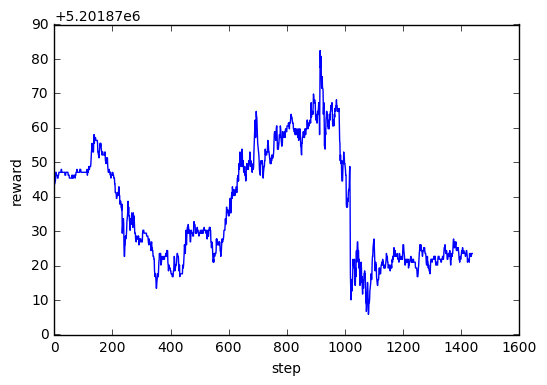

In [ ]:
is_to_train = False
if is_to_train:
    dfx.train(is_for_time_measurement=True)
else:
    dfx.test(1, [EpisodeLogger()])